In [1]:
from __future__ import division

In [2]:
%run util.py

In [3]:
data_dir = "/home/jzh/Dropbox/Research/Anomaly_Detection/ROCHM/data_dir/"

In [4]:
def wcKLs_testSet(N, n):
    # mu_0: the initial distribution; 1 x (N**2) 
    # mu: the actual stationary distribution; 1 x (N**2)
    # mu_1: the estimated stationary distribution 
    # P: the new transition matrix (the old transition matrix is Q)
    # G_1: the estimate of the gradient
    # H_1: the estimate of the Hessian

    # P is the ground truth transition matrix
    mu_0, mu, mu_1, P, G_1, H_1, Sigma_1, W_1, rho_1, Chi_1 = ChainGen(N)  

    # PP is a different transition matrix for testing purposes
    mu_0P, muP, mu_1P, PP, G_1P, H_1P, Sigma_1P, W_1P, rho_1P, Chi_1P = ChainGen(N) 

    KL_wc_1, KL_wc_2, _, _ = ThresWeakConv(N, 0.1, rho_1, n, mu_0, mu, mu_1, P, \
                                                           G_1, H_1, Sigma_1, W_1, Chi_1).ThresCal()
    
    negative_sample = {}
    positive_sample = {}

    # Get sample paths of the Markov chain with length n; 
    # these paths will be the test set
    for idx in range(int(num_test_sample/2)):
        negative_sample[idx] = chain(mu, P, n)
    for idx in range(int(num_test_sample/2)):
        positive_sample[idx] = chain(muP, PP, n)
    
    mu = np.reshape(mu, (N, N))
    negative_sample_KL = {}
    positive_sample_KL = {}
    
    # Compute KL divergence values w.r.t. mu for each sample
    for idx in range(int(num_test_sample/2)):
        negative_sample_KL[idx] = KL_est(negative_sample[idx], mu)
        
    for idx in range(int(num_test_sample/2)):
        positive_sample_KL[idx] = KL_est(positive_sample[idx], mu)
        
    return KL_wc_1, KL_wc_2, negative_sample_KL, positive_sample_KL

In [5]:
def roc_data(n, beta, KL_wc_1, KL_wc_2, negative_sample_KL, positive_sample_KL):
    
    # Get thresholds for Hoeffding's test corresponding to sample length n    
    key = str(n) + "_" + str(beta)
    
    eta_wc_1 = {}
    eta_wc_2 = {}
    eta_sv = {}

    eta_wc_v1 = prctile(KL_wc_1, 100 * (1 - beta))
    eta_wc_v2 = prctile(KL_wc_2, 100 * (1 - beta))
    eta_sav = - log(beta) / n
    
    eta_wc_1[key] = eta_wc_v1
    eta_wc_2[key] = eta_wc_v2
    eta_sv[key] = eta_sav

    negative_sample_wc_1 = {}
    negative_sample_wc_2 = {}
    negative_sample_sv = {}

    positive_sample_wc_1 = {}
    positive_sample_wc_2 = {}
    positive_sample_sv = {}

    for idx in range(int(num_test_sample/2)):
        if negative_sample_KL[idx] > eta_wc_1[key]:
            negative_sample_wc_1[idx] = 1
        else:
            negative_sample_wc_1[idx] = -1
        if negative_sample_KL[idx] > eta_wc_2[key]:
            negative_sample_wc_2[idx] = 1
        else:
            negative_sample_wc_2[idx] = -1
        if negative_sample_KL[idx] > eta_sv[key]:
            negative_sample_sv[idx] = 1
        else:
            negative_sample_sv[idx] = -1    


    for idx in range(int(num_test_sample/2)):
        if positive_sample_KL[idx] > eta_wc_1[key]:
            positive_sample_wc_1[idx] = 1
        else:
            positive_sample_wc_1[idx] = -1
        if positive_sample_KL[idx] > eta_wc_2[key]:
            positive_sample_wc_2[idx] = 1
        else:
            positive_sample_wc_2[idx] = -1
        if positive_sample_KL[idx] > eta_sv[key]:
            positive_sample_sv[idx] = 1
        else:
            positive_sample_sv[idx] = -1 

    TP_wc_1 = count_one(positive_sample_wc_1.values())[0]
    FP_wc_1 = count_one(negative_sample_wc_1.values())[0]
    TN_wc_1 = count_one(negative_sample_wc_1.values())[1]
    FN_wc_1 = count_one(positive_sample_wc_1.values())[1]
    TPR_wc_1 = TP_wc_1 / (TP_wc_1 + FN_wc_1)
    FPR_wc_1 = FP_wc_1 / (FP_wc_1 + TN_wc_1)
    Precision_wc_1 = TP_wc_1 / (TP_wc_1 + FP_wc_1)
    Recall_wc_1 = TP_wc_1 / (TP_wc_1 + FN_wc_1)
    assert(TP_wc_1 + FN_wc_1 == int(num_test_sample/2))
    assert(FP_wc_1 + TN_wc_1 == int(num_test_sample/2))
    assert(Recall_wc_1 == TPR_wc_1)

    TP_wc_2 = count_one(positive_sample_wc_2.values())[0]
    FP_wc_2 = count_one(negative_sample_wc_2.values())[0]
    TN_wc_2 = count_one(negative_sample_wc_2.values())[1]
    FN_wc_2 = count_one(positive_sample_wc_2.values())[1]
    TPR_wc_2 = TP_wc_2 / (TP_wc_2 + FN_wc_2)
    FPR_wc_2 = FP_wc_2 / (FP_wc_2 + TN_wc_2)
    Precision_wc_2 = TP_wc_2 / (TP_wc_2 + FP_wc_2)
    Recall_wc_2 = TP_wc_2 / (TP_wc_2 + FN_wc_2)
    assert(TP_wc_2 + FN_wc_2 == int(num_test_sample/2))
    assert(FP_wc_2 + TN_wc_2 == int(num_test_sample/2))
    assert(Recall_wc_2 == TPR_wc_2)

    TP_sv = count_one(positive_sample_sv.values())[0]
    FP_sv = count_one(negative_sample_sv.values())[0]
    TN_sv = count_one(negative_sample_sv.values())[1]
    FN_sv = count_one(positive_sample_sv.values())[1]
    TPR_sv = TP_sv / (TP_sv + FN_sv)
    FPR_sv = FP_sv / (FP_sv + TN_sv)
    Precision_sv = TP_sv / (TP_sv + FP_sv)
    Recall_sv = TP_sv / (TP_sv + FN_sv)
    assert(TP_sv + FN_sv == int(num_test_sample/2))
    assert(FP_sv + TN_sv == int(num_test_sample/2))
    assert(Recall_sv == TPR_sv)

    data_wc_1 = {"TPR": TPR_wc_1, "FPR":FPR_wc_1, "Precision":Precision_wc_1, "Recall":Recall_wc_1}
    data_wc_2 = {"TPR": TPR_wc_2, "FPR":FPR_wc_2, "Precision":Precision_wc_2, "Recall":Recall_wc_2}
    data_sv = {"TPR": TPR_sv, "FPR":FPR_sv, "Precision":Precision_sv, "Recall":Recall_sv}
    
    return data_wc_1, data_wc_2, data_sv

In [6]:
N = 8
n = 200
num_test_sample = 2000

In [7]:
beta_list = [1e-3] + list(np.arange(0, 0.21, 0.01)[1:-1])

In [8]:
beta_list

[0.001,
 0.01,
 0.02,
 0.029999999999999999,
 0.040000000000000001,
 0.050000000000000003,
 0.059999999999999998,
 0.070000000000000007,
 0.080000000000000002,
 0.089999999999999997,
 0.10000000000000001,
 0.11,
 0.12,
 0.13,
 0.14000000000000001,
 0.14999999999999999,
 0.16,
 0.17000000000000001,
 0.17999999999999999,
 0.19]

In [9]:
KL_wc_1, KL_wc_2, negative_sample_KL, positive_sample_KL = wcKLs_testSet(N, n)

<string>:330: RuntimeWarning: covariance is not positive-semidefinite.


In [10]:
roc_data_wc_1 = {}
roc_data_wc_2 = {}
roc_data_sv = {}

for beta in beta_list:
    roc_data_wc_1[beta], roc_data_wc_2[beta], roc_data_sv[beta] = \
    roc_data(n, beta, KL_wc_1, KL_wc_2, negative_sample_KL, positive_sample_KL)

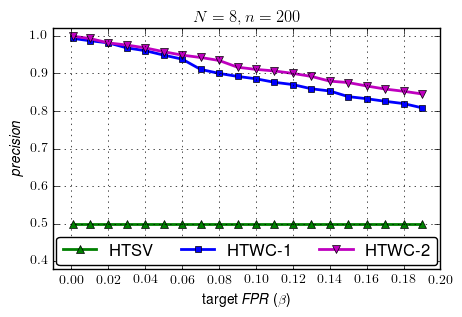

In [22]:
import matplotlib.pyplot as plt
import pylab
from pylab import *
%matplotlib inline  
import itertools 


plt.figure(figsize=(5, 3.1))

font = {"family" : "normal",
        "weight" : "normal",
        "size"   : 20}

# from matplotlib import rc
# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
# ## for Palatino and other serif fonts use:
# #rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

roc_sv_pr, = plt.plot([beta for beta in beta_list], \
                   [roc_data_sv[beta]["Precision"] for beta in beta_list], "g-^", linewidth=2)
roc_wc_1_pr, = plt.plot([beta for beta in beta_list], \
                     [roc_data_wc_1[beta]["Precision"] for beta in beta_list], "b-s", linewidth=2, markersize=5)
roc_wc_2_pr, = plt.plot([beta for beta in beta_list], \
                     [roc_data_wc_2[beta]["Precision"] for beta in beta_list], "m-v", linewidth=2)

legend_list = [r"HTSV", r"HTWC-1", r"HTWC-2"]

# legend(loc=0, fancybox="true", ncol=2, mode="expand", borderaxespad=0.2) 

plt.legend([roc_sv_pr, roc_wc_1_pr, roc_wc_2_pr], \
           legend_list, loc=4, ncol=3, mode="expand", borderaxespad=0.2, numpoints=1, fancybox="true")
plt.title(r"$N = %s, n = %s$"%(N, n))
plt.xticks(np.arange(-0.02, 0.24, 0.02)[1:-1])

pylab.xlim(-0.01, 0.2)
pylab.ylim(0.38, 1.02)

plt.xlabel(r"target \textit{FPR} ($\beta$)")
plt.ylabel(r"\textit{precision}")
plt.grid()


savefig(data_dir + "ROC_data_precision_N_%s_n_%s.eps"%(N, n))

plt.show()

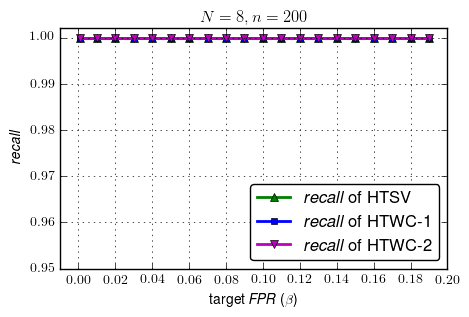

In [20]:
import matplotlib.pyplot as plt
import pylab
from pylab import *
%matplotlib inline  
import itertools 


plt.figure(figsize=(5, 3.1))

font = {"family" : "normal",
        "weight" : "normal",
        "size"   : 20}

from matplotlib import rc
# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
# ## for Palatino and other serif fonts use:
# #rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

roc_sv_pr, = plt.plot([beta for beta in beta_list], \
                   [roc_data_sv[beta]["Recall"] for beta in beta_list], "g-^", linewidth=2)
roc_wc_1_pr, = plt.plot([beta for beta in beta_list], \
                     [roc_data_wc_1[beta]["Recall"] for beta in beta_list], "b-s", linewidth=2, markersize=5)
roc_wc_2_pr, = plt.plot([beta for beta in beta_list], \
                     [roc_data_wc_2[beta]["Recall"] for beta in beta_list], "m-v", linewidth=2)

legend_list = [r"\textit{recall} of HTSV", r"\textit{recall} of HTWC-1", r"\textit{recall} of HTWC-2"]

# legend(loc=0, fancybox="true", ncol=2, mode="expand", borderaxespad=0.2) 

plt.legend([roc_sv_pr, roc_wc_1_pr, roc_wc_2_pr], \
           legend_list, loc=4, numpoints=1, fancybox="false")
plt.title(r"$N = %s, n = %s$"%(N, n))
plt.xticks(np.arange(-0.02, 0.24, 0.02)[1:-1])

pylab.xlim(-0.01, 0.2)
pylab.ylim(0.95, 1.002)

plt.xlabel(r"target \textit{FPR} ($\beta$)")
plt.ylabel(r"\textit{recall}")
plt.grid()


savefig(data_dir + "ROC_data_recall_N_%s_n_%s.eps"%(N, n))

plt.show()

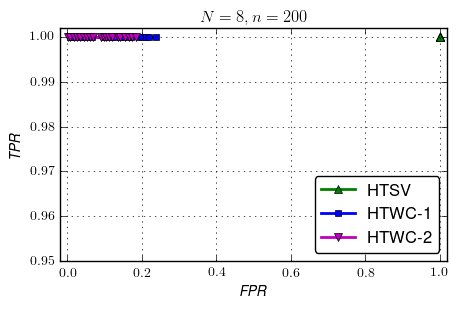

In [18]:
import matplotlib.pyplot as plt
import pylab
from pylab import *
%matplotlib inline  
import itertools 


plt.figure(figsize=(5, 3))

font = {"family" : "normal",
        "weight" : "normal",
        "size"   : 20}

from matplotlib import rc
# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
# ## for Palatino and other serif fonts use:
# #rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

roc_sv_re, = plt.plot([roc_data_sv[beta]["FPR"] for beta in beta_list], \
                   [roc_data_sv[beta]["Recall"] for beta in beta_list], "g-^", linewidth=2)
roc_wc_1_re, = plt.plot([roc_data_wc_1[beta]["FPR"] for beta in beta_list], \
                     [roc_data_wc_1[beta]["Recall"] for beta in beta_list], "b-s", linewidth=2, markersize=5)
roc_wc_2_re, = plt.plot([roc_data_wc_2[beta]["FPR"] for beta in beta_list], \
                     [roc_data_wc_2[beta]["Recall"] for beta in beta_list], "m-v", linewidth=2)

legend_list = ["HTSV", "HTWC-1", "HTWC-2"]

# legend(loc=0, fancybox="true", ncol=2, mode="expand", borderaxespad=0.2) 

plt.legend([roc_sv_re, roc_wc_1_re, roc_wc_2_re], \
           legend_list, loc=4, numpoints=1, fancybox="false")
plt.title(r"$N = %s, n = %s$"%(N, n))
# plt.xticks(N_list)

pylab.xlim(-0.02, 1.02)
pylab.ylim(0.95, 1.002)

plt.xlabel(r"\textit{FPR}")
plt.ylabel(r"\textit{TPR}")
plt.grid()


savefig(data_dir + "ROC_graph_N_%s_n_%s.eps"%(N, n))

plt.show()

In [14]:
roc_data_all = {"wc_1": roc_data_wc_1, "wc_2": roc_data_wc_2, "sv": roc_data_sv}

In [15]:
roc_data_all

{'sv': {0.001: {'FPR': 1.0, 'Precision': 0.5, 'Recall': 1.0, 'TPR': 1.0},
  0.01: {'FPR': 1.0, 'Precision': 0.5, 'Recall': 1.0, 'TPR': 1.0},
  0.02: {'FPR': 1.0, 'Precision': 0.5, 'Recall': 1.0, 'TPR': 1.0},
  0.029999999999999999: {'FPR': 1.0,
   'Precision': 0.5,
   'Recall': 1.0,
   'TPR': 1.0},
  0.040000000000000001: {'FPR': 1.0,
   'Precision': 0.5,
   'Recall': 1.0,
   'TPR': 1.0},
  0.050000000000000003: {'FPR': 1.0,
   'Precision': 0.5,
   'Recall': 1.0,
   'TPR': 1.0},
  0.059999999999999998: {'FPR': 1.0,
   'Precision': 0.5,
   'Recall': 1.0,
   'TPR': 1.0},
  0.070000000000000007: {'FPR': 1.0,
   'Precision': 0.5,
   'Recall': 1.0,
   'TPR': 1.0},
  0.080000000000000002: {'FPR': 1.0,
   'Precision': 0.5,
   'Recall': 1.0,
   'TPR': 1.0},
  0.089999999999999997: {'FPR': 1.0,
   'Precision': 0.5,
   'Recall': 1.0,
   'TPR': 1.0},
  0.10000000000000001: {'FPR': 1.0,
   'Precision': 0.5,
   'Recall': 1.0,
   'TPR': 1.0},
  0.11: {'FPR': 1.0, 'Precision': 0.5, 'Recall': 1.0, 'TP